# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

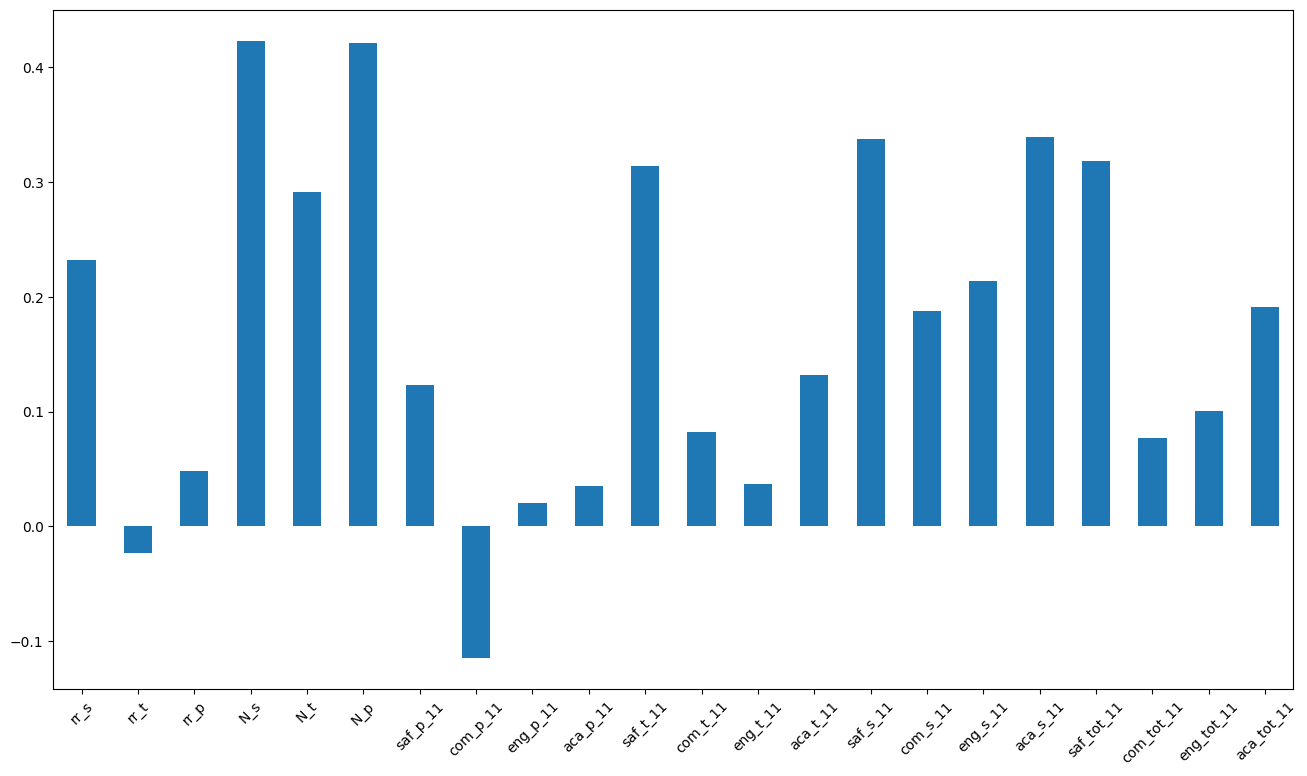

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

correlations[survey_fields].plot.bar(figsize=(16, 9), rot=45)

There are few quite hight correlations between the SAT score and:
* Number of respondents from each group(`N_s`, `N_t` and `N_p`) 
* Academic expectations score based on student responses(`aca_s_11`)
* Safety and Respect score from each group(`saf_t_11`, `saf_s_11` and `saf_tot_11`)

More respondents mean more impact I suppose.

Student's academic expectaions probably force these students to prepare better for the tests. So results are higher.

But from my opition the most intresting and also the most obvious is correlation with safety and respect score. It should be really difficult to study while you are unsafe. It is remarkable that SAT score correletes with total safety and respect score. This is the only one category with such correlation.

## Safety and Respect correlation

Let's take a closer to the safety and respect score with SAT score correlation. Make a scattter plot.

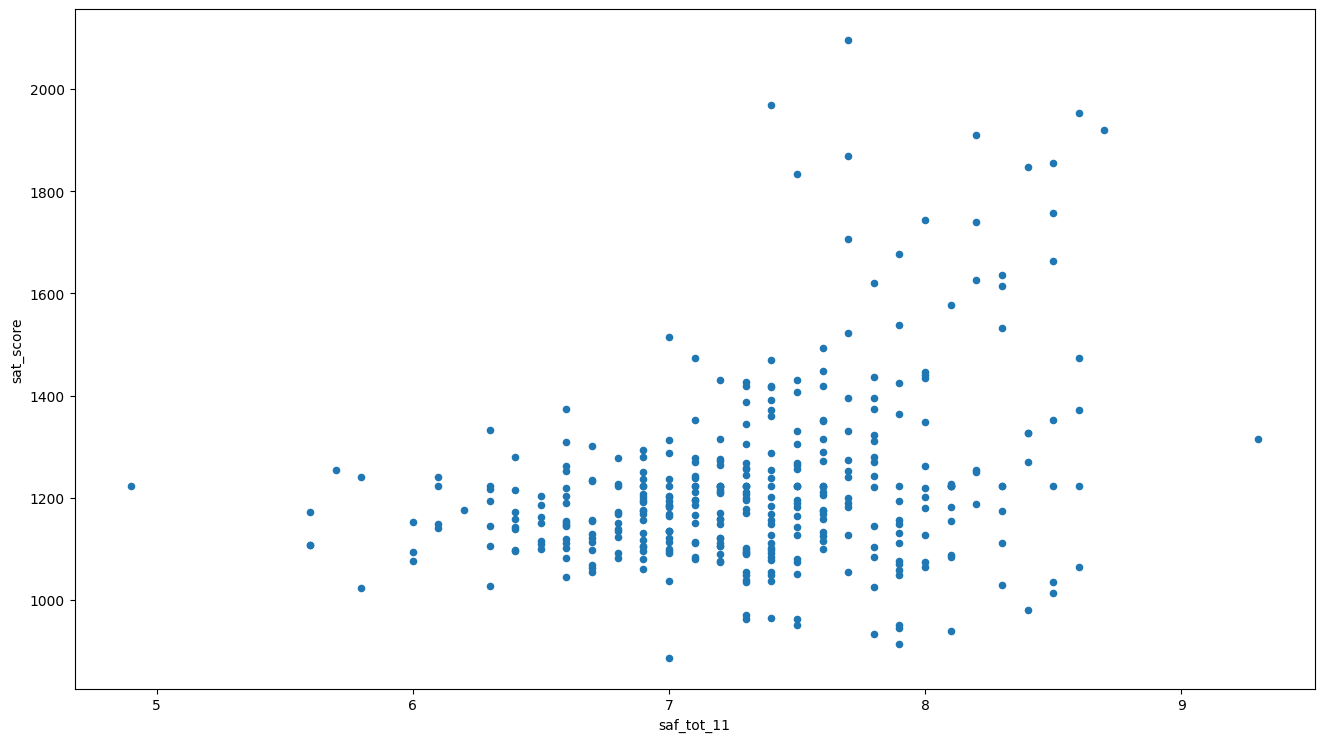

In [12]:
combined.plot.scatter(x='saf_tot_11', y='sat_score', figsize=(16, 9))

It seems like students from scholls with more than 7 safery scores achive significantly better SAT results. Up to 2100 SAT scores.

Safety scores below 7 limit to about 1550 SAT scores.

Let's compute safety scores for each borough next.

In [13]:
combined.groupby('boro')['saf_tot_11'].mean()

boro
Bronx            7.322581
Brooklyn         7.129245
Manhattan        7.473333
Queens           7.387500
Staten Island    7.200000
Name: saf_tot_11, dtype: float64

There are no huge differences between boroughs as I can see.

## Race correlations

There are a few columns that indicate the percentage of each race at a given school:
* `white_per`
* `asian_per`
* `black_per`
* `hispanic_per`

Let's examine correlations between these columns and SAT scores.

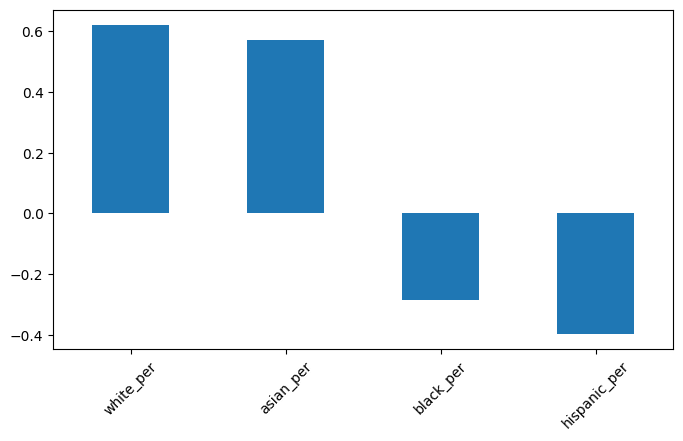

In [14]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

correlations[race_cols].plot.bar(figsize=(8, 4.5), rot=45)

Unfortunately there are quite expected correlations. Higher percentage of black or hispanic students correlates negatively with SAT score.

Let's explore correlation with `hispanic_per` a bit more.

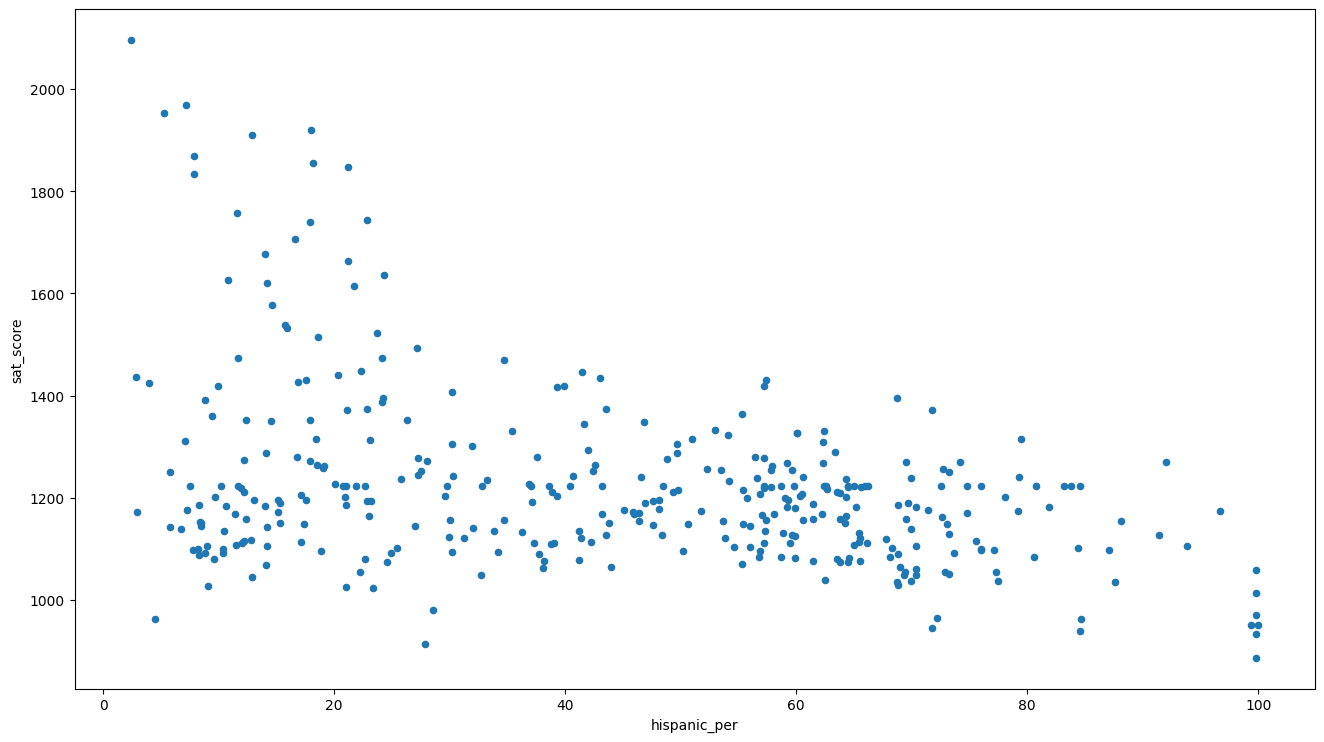

In [15]:
combined.plot.scatter(x='hispanic_per', y='sat_score', figsize=(16, 9))

SAT scores are below **1500** at schools with more than **30%** of hispanic students. There are greater results in schools with lower percentages of hispanic students.

Let's get school list with `hispanic_per` greater than **95%**.

In [16]:
combined.loc[combined['hispanic_per'] > 95, 'SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

From quick google searching we can say that most schools are set up for immigrants from Spanish speaking countries. They spend a lot of time to learn English so SAT results are low.

Now let's get school list with `hispanic_per` less than **10%** and SAT score greater than **1800**.

In [17]:
combined.loc[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800), 'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

All of these schools are specialized [high schools of New York City](https://en.wikipedia.org/wiki/Specialized_high_schools_in_New_York_City). They serve the needs of academically and artistically gifted students. Great SAT results are clear.

## Sex correlations

Let's build a plot to see correlations between SAT score and male and female percentage of number of students.

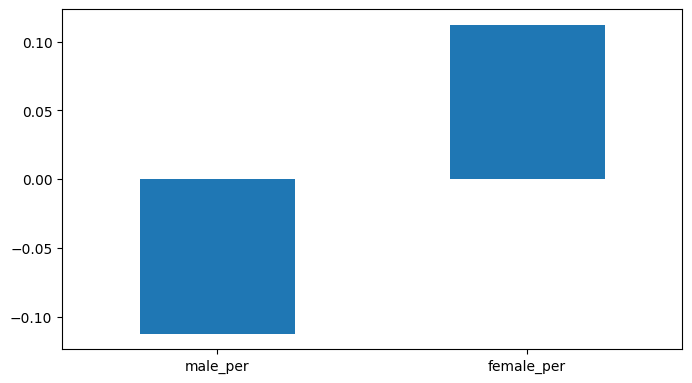

In [18]:
sex_cols = ['male_per', 'female_per']

correlations[sex_cols].plot.bar(figsize=(8, 4.5), rot=0)

Looks like girls are better at the SAT test! The `female_per` column has small correlations with the `sat_score` column. Take a closer look.

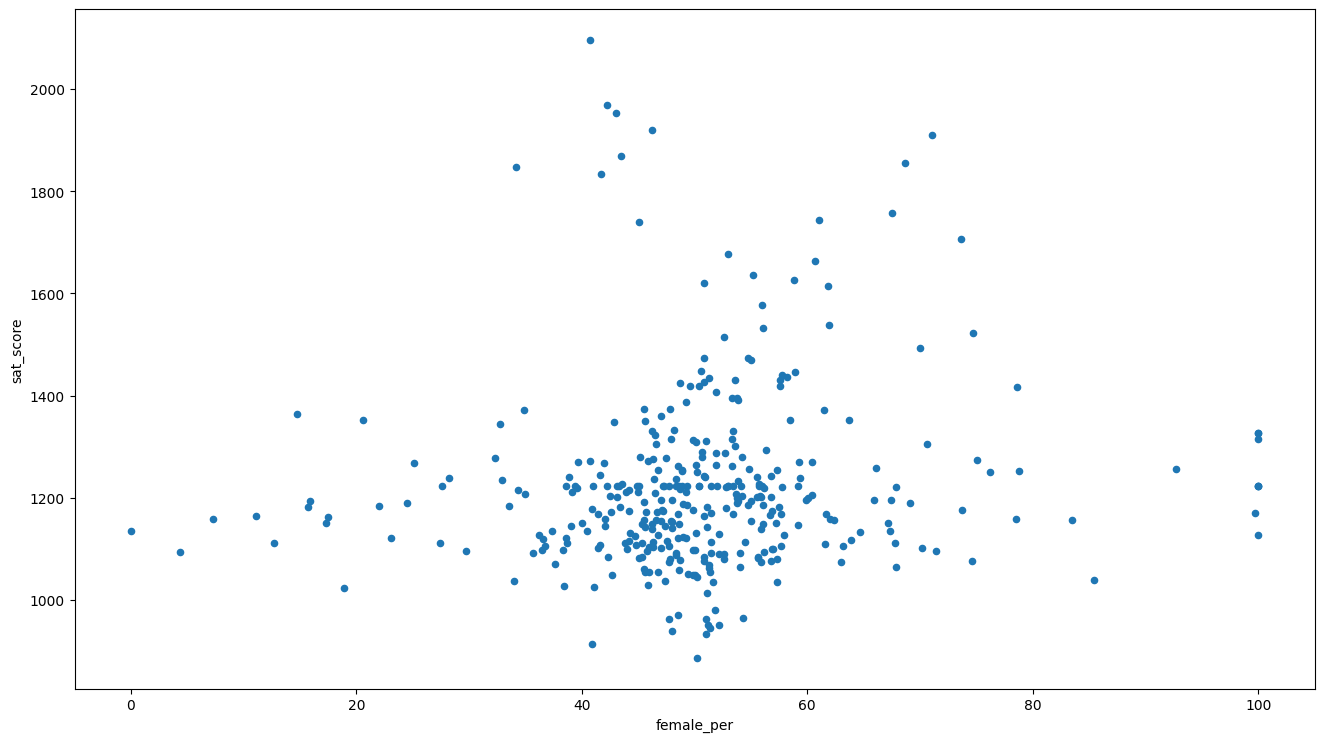

In [19]:
combined.plot.scatter(x='female_per', y='sat_score', figsize=(16, 9))

There are tw ogroups of dots with high SAT scores:
* With `female_per` between **40%** and **50%**
* With `female_per` between **60%** and **80%**

The seacond one is more signficant, we analize these schools.

In [20]:
combined.loc[(combined['female_per'] < 60) & (combined['sat_score'] > 1700), 'SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools are also specialized [high schools of New York City](https://en.wikipedia.org/wiki/Specialized_high_schools_in_New_York_City)! It is explaining high SAT scores.

## AP exams and SAT score

In the U.S., high school students take [Advanced Placement (AP) exams](https://en.wikipedia.org/wiki/Advanced_Placement_exams) to earn college credit. There are AP exams for many different subjects.

It would make sense that the number of students at a school who took AP exams correlates with the school's SAT scores. Let's explore this relationship.
For that we'll calculate the percentage of students in each school that took an AP exam and build scatter plot of these values vs SAT scores.

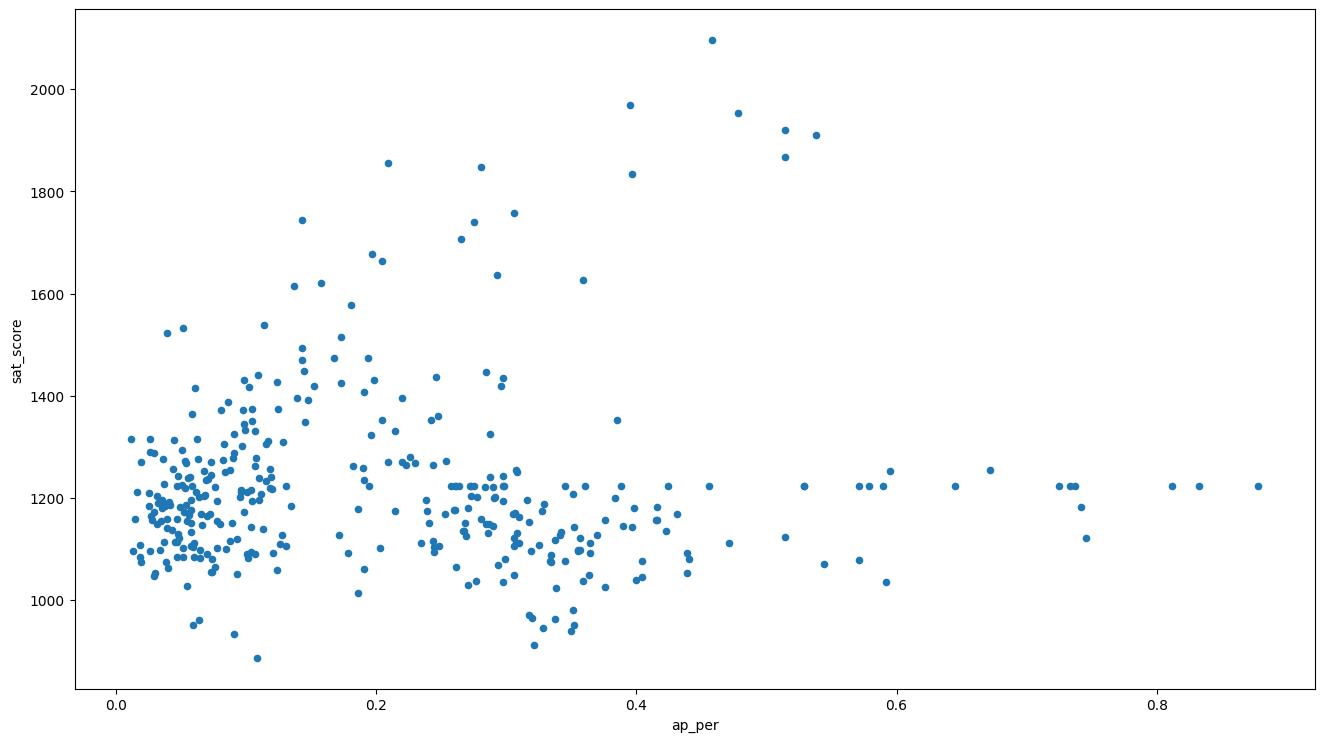

In [22]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score', figsize=(16, 9))

The most schools score is about **1200** or less regardless of the number of students taking AP exams. There is even a straight line on the plot for **1200** scores.

But we're looking for high results correlations. What about it?

There is increasing trend for SAT scores above **1200** while `ap_per` is growing as I can see. Interesting that this trend appears only for `ap_per` from **0%** to **55%**. The highest SAT score values achivied in schools with **40-55%** students taking AP exam.

Every SAT score is about **1200** again in scholls with `ap_per` is above **55%**. Probably too much time and resourses are spent for AP exam so SAT tests are kind of failed.